# Pneumococcus modelling codes 

_Streptococcus pneumoniae_ (or 'pneumococcus') simulation codes used to explore possible transmission structures and dynamical properties.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pylab
import scipy.special as spec
import time

### Single serotype per person and exponential recovery time model

Start with a simple Markovian (exponentially-distributed in event time) recovery rate for each serotype. This first model will be based on the household-community split (as in [https://academic.oup.com/aje/article/166/2/228/98916]) with the following transmission probabilities for individuals (who we shall assume can only carry a single serotype at a time) within household $h$ (in which one event will occur per unit timestep) of age $a$, and the $i$-th serotype, over time interval $\delta t$

$${\rm Pr}({\cal I}^h_{ai}\rightarrow {\cal I}^h_{ai}-1,S^h_{a}\rightarrow S^h_{a}+1,\delta t) = \mu_{ai}{\cal I}^h_{ai}(t)\delta t$$
$${\rm Pr}({\cal I}^h_{ai}\rightarrow {\cal I}^h_{ai}+1,S^h_{a}\rightarrow S^h_{a}-1,\delta t)  = \Lambda^h_{ai}(t)\delta t$$
$${\rm Pr}({\cal I}^h_{ai}\rightarrow {\cal I}^h_{ai}+1,{\cal I}^h_{ai'}\rightarrow {\cal I}^h_{ai'}-1,\delta t) = f_{i'i}\Lambda^h_{ai}(t)\delta t$$
$${\rm Pr}({\cal I}^h_{ai}\rightarrow {\cal I}^h_{ai}-1,{\cal I}^h_{ai'}\rightarrow {\cal I}^h_{ai'}+1,\delta t) = f_{ii'}\Lambda^h_{ai'}(t)\delta t$$

where ${\cal I}^h_{ai}(t)$ denotes the number of infective individuals of age $a$ with serotype $i$ in the household, $S^h_{a}(t)$ denotes the number of susceptible individuals of age $a$ in the household, $f_{ii'}$ is the serotype competition matrix and $\mu_{ai}$ denotes the recovery rate of an individual of age $a$ from the $i$-th serotype. The force of infection $\Lambda^h_{ai}(t)$ is split into household $\lambda^h_{ai}(t)$ (with $N_h$ individuals living within it) and community $\lambda^{\rm com}_{ai}(t)$ parts in the following way

$$\Lambda^h_{ai}(t)=\lambda^h_{ai}(t)+\lambda^{h-{\rm com}}_{ai}(t)= \frac{1}{N_h-1}\sum_{\forall a'} \beta^{a'}_{ai}{\cal I}^h_{a'i}(t) + \frac{\alpha}{(\sum_{\forall h}N_h)-N_h}\sum_{\forall a'}\sum_{\forall h' \neq h} \beta^{a'}_{ai}{\cal I}^{h'}_{a'i}(t)\,.$$

In the above expression, $\beta^{a'}_{ai}$ is the contact rate between individuals of ages $a$ and $a'$ for the $i$-th serotype, and $\alpha$ (<1) encodes the damping of community contact relative to the household. For computation speed, we can redefine the community term in the force of infection above for an individual in terms of the of the 'total community force of infection' $L_{ai}(t)$ for each age group and serotype like so

$$\lambda^{h-{\rm com}}_{ai}(t) = \frac{\alpha}{(\sum_{\forall h}N_h)-N_h}\left[ L_{ai}(t) -\sum_{\forall a'}\beta^{a'}_{ai}{\cal I}^{h}_{a'i}(t) \right]\,,$$

where $L_{ai}(t)$ is defined as

$$L_{ai}(t) \equiv \sum_{\forall a'}\sum_{\forall h} \beta^{a'}_{ai}{\cal I}^{h}_{a'i}(t)\,,$$

such that 

$$\Lambda^h_{ai}(t)=\left[ \frac{1}{N_h-1} -\frac{\alpha}{(\sum_{\forall h}N_h)-N_h}\right]\sum_{\forall a'} \beta^{a'}_{ai}{\cal I}^h_{a'i}(t) + \frac{\alpha}{(\sum_{\forall h}N_h)-N_h}L_{ai}(t)\,.$$

A simple code which corresponds to this system is below. The key parameters are set first here...

In [2]:
number_of_households = 100
number_of_serotypes = 100
demographic_household_fractions = [0.3,0.4,0.3] # [Children,Adults,Elderly]
alpha_damping = 0.1
number_of_realisations = 100
realisations_per_run = 10                       # Should be a factor of the number of realisations
time_at_beginning = 0.0                         # In units of years
time_at_end = 1.0                               # In units of years
do_nothing_timescale = 0.01                     # In units of years

# Parameters for the output plot stack
set_number_of_plot_columns = 10
set_number_of_plot_rows = 10

...then the contact rates, recovery rates and competition matrix...

In [3]:
children_to_adult_contact_rates = np.ones(number_of_serotypes)
children_to_elderly_contact_rates = np.ones(number_of_serotypes)
adult_to_elderly_contact_rates = np.ones(number_of_serotypes)
competition_matrix = np.ones((number_of_serotypes,number_of_serotypes))-np.identity(number_of_serotypes) 
recovery_rates = np.ones(number_of_serotypes)

...then the initial prevalences for all serotypes...

In [4]:
initial_prevalences = np.random.uniform(size=number_of_serotypes)

...and finally the algorithm is... 

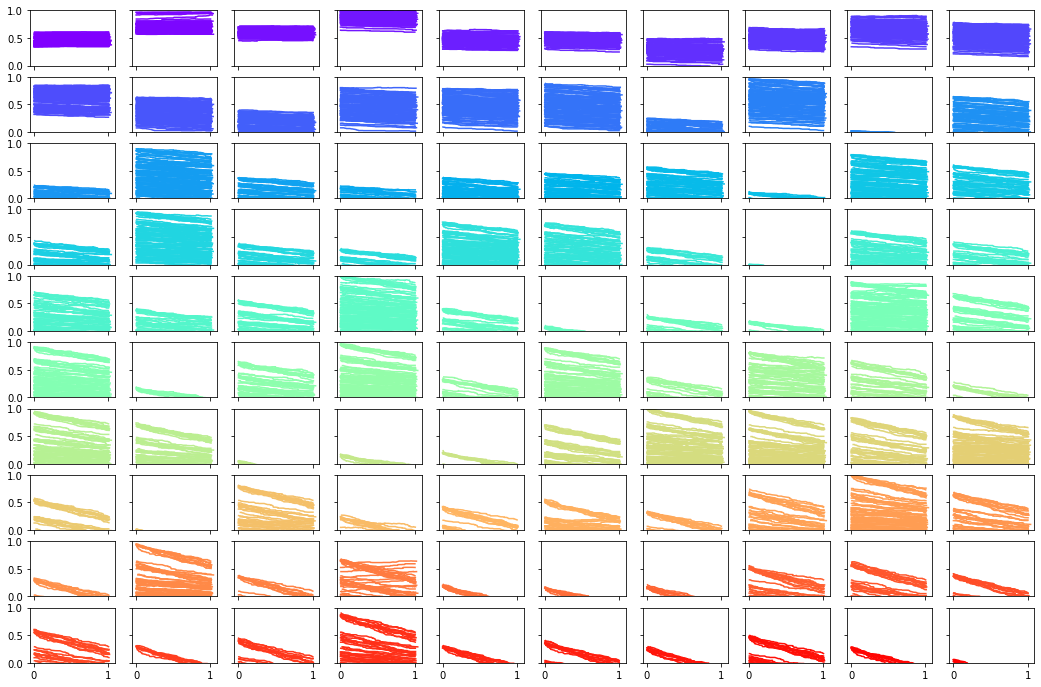

In [12]:
# Draw the number of people within each household
household_people_numbers = np.random.randint(1,10,size=number_of_households)
total_number_of_people = np.sum(household_people_numbers)

# Set the demographic numbers within each household
demographic_numbers = np.asarray([np.random.multinomial(hp,demographic_household_fractions) \
                                  for hp in household_people_numbers]).T
number_of_children_in_each_household = demographic_numbers[0]
number_of_adults_in_each_household = demographic_numbers[1]
number_of_elderly_in_each_household = demographic_numbers[2]

# Generate initial matrices of infectives - dimension 0 is the household ID, 
# dimension 1 is the serotype and dimension 2 is the realisation
household_children_infectives=np.random.binomial(np.tensordot(number_of_children_in_each_household,\
                              np.ones((number_of_serotypes,realisations_per_run)),axes=0).astype(int),\
                              np.tensordot(np.tensordot(np.ones(number_of_households),\
                              initial_prevalences,axes=0),np.ones(realisations_per_run),axes=0),\
                              size=(number_of_households,number_of_serotypes,realisations_per_run))
household_adult_infectives=np.random.binomial(np.tensordot(number_of_adults_in_each_household,\
                           np.ones((number_of_serotypes,realisations_per_run)),axes=0).astype(int),\
                           np.tensordot(np.tensordot(np.ones(number_of_households),\
                           initial_prevalences,axes=0),np.ones(realisations_per_run),axes=0),\
                           size=(number_of_households,number_of_serotypes,realisations_per_run))
household_elderly_infectives=np.random.binomial(np.tensordot(number_of_elderly_in_each_household,\
                             np.ones((number_of_serotypes,realisations_per_run)),axes=0).astype(int),\
                             np.tensordot(np.tensordot(np.ones(number_of_households),\
                             initial_prevalences,axes=0),np.ones(realisations_per_run),axes=0),\
                             size=(number_of_households,number_of_serotypes,realisations_per_run))

# Initialise subplots and colours of lines in each plot
fig, ax = plt.subplots(nrows=set_number_of_plot_rows,ncols=set_number_of_plot_columns)
colours = cm.rainbow(np.linspace(0,1,number_of_serotypes))

# Compute the number of runs required and initialise main loop
number_of_runs = int(number_of_realisations/realisations_per_run)
for n in range(0,number_of_runs):
    
    # Generate tensor of household numbers for each age group 
    number_of_children_in_each_household_tensor = np.tensordot(number_of_children_in_each_household,\
                                                  np.ones((number_of_serotypes,realisations_per_run)),axes=0)
    number_of_adults_in_each_household_tensor = np.tensordot(number_of_adults_in_each_household,\
                                                np.ones((number_of_serotypes,realisations_per_run)),axes=0)
    number_of_elderly_in_each_household_tensor = np.tensordot(number_of_elderly_in_each_household,\
                                                 np.ones((number_of_serotypes,realisations_per_run)),axes=0)

    # Initialise storage for plot data
    plot_data = []
    plot_data_times = []
    
    # Initialise plot loop parameters
    rown = 0
    columnn = 0
    
    # Initialise time and run over realisations
    t = time_at_beginning*np.ones(realisations_per_run)
    terminated_realisations_per_run = np.ones(realisations_per_run)
    slowest_t = time_at_beginning
    while slowest_t < time_at_end:
    
        # Iterate forward in time 
        t = t + terminated_realisations_per_run*np.random.exponential(scale=do_nothing_timescale,\
                                                                      size=realisations_per_run)    
        # Set slowest time
        slowest_t = np.ndarray.min(t)
    
        # Event realisations at this timestep
        event_realisations = np.tensordot(np.random.uniform(size=(number_of_households,realisations_per_run)),\
                                          np.ones(number_of_serotypes),axes=0)
        event_realisations = np.swapaxes(event_realisations,1,2)
        
        # Total community forces of infection for each age group
        children_total_community_force_of_infection=np.sum((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_adult_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_adult_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_elderly_infectives),axis=0)
        adult_total_community_force_of_infection=np.sum((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_adult_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_children_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             adult_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_elderly_infectives),axis=0)
        elderly_total_community_force_of_infection=np.sum((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             children_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_children_infectives) + \
                                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                                             adult_to_elderly_contact_rates,axes=0),\
                                                             np.ones(realisations_per_run),axes=0)*\
                                                             household_adult_infectives),axis=0)
        
        # Recovery event rates for each age group
        children_recovery_event_rates = household_children_infectives*np.tensordot(np.ones(number_of_households),\
                                        np.tensordot(recovery_rates,np.ones(realisations_per_run),axes=0),axes=0)
        adult_recovery_event_rates = household_adult_infectives*np.tensordot(np.ones(number_of_households),\
                                     np.tensordot(recovery_rates,np.ones(realisations_per_run),axes=0),axes=0)
        elderly_recovery_event_rates = household_elderly_infectives*np.tensordot(np.ones(number_of_households),\
                                       np.tensordot(recovery_rates,np.ones(realisations_per_run),axes=0),axes=0)
        
        # Calculate the total number of infectives in each household to consistently compute the replacement event rates
        total_household_children_infectives = np.swapaxes(np.tensordot(np.sum(household_children_infectives,axis=1),\
                                                          np.ones(number_of_serotypes),axes=0),1,2)
        total_household_adult_infectives = np.swapaxes(np.tensordot(np.sum(household_adult_infectives,axis=1),\
                                                       np.ones(number_of_serotypes),axes=0),1,2)
        total_household_elderly_infectives = np.swapaxes(np.tensordot(np.sum(household_elderly_infectives,axis=1),\
                                                         np.ones(number_of_serotypes),axes=0),1,2)
        
        # Calculate the total number of suceptibles in each household to consistently compute the new carriage event rates
        total_household_children_susceptibles = number_of_children_in_each_household_tensor - \
                                                total_household_children_infectives
        total_household_adult_susceptibles = number_of_adults_in_each_household_tensor - \
                                             total_household_adult_infectives
        total_household_elderly_susceptibles = number_of_elderly_in_each_household_tensor - \
                                               total_household_elderly_infectives
        
        # New carriage event rates for each age group (also the forces of infection)
        children_new_carriage_event_rates=(total_household_children_susceptibles>0)*\
                                          ((np.tensordot((household_people_numbers>1)/((household_people_numbers>1)*\
                                            household_people_numbers.astype(float)-1.0),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0)-\
                                            np.tensordot(alpha_damping/(float(total_number_of_people)-\
                                            household_people_numbers.astype(float)),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0))*\
                                            ((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                            children_to_adult_contact_rates,axes=0),\
                                            np.ones(realisations_per_run),axes=0)*\
                                            household_adult_infectives) + \
                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                            children_to_elderly_contact_rates,axes=0),\
                                            np.ones(realisations_per_run),axes=0)*\
                                            household_elderly_infectives))) + \
                                            (np.tensordot(alpha_damping/(float(total_number_of_people)-\
                                            household_people_numbers.astype(float)),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0)*\
                                            (np.tensordot(np.ones(number_of_households),\
                                            children_total_community_force_of_infection,axes=0)))   
        adult_new_carriage_event_rates=(total_household_adult_susceptibles>0)*\
                                       ((np.tensordot((household_people_numbers>1)/((household_people_numbers>1)*\
                                            household_people_numbers.astype(float)-1.0),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0)-\
                                            np.tensordot(alpha_damping/(float(total_number_of_people)-\
                                            household_people_numbers.astype(float)),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0))*\
                                            ((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                            children_to_adult_contact_rates,axes=0),\
                                            np.ones(realisations_per_run),axes=0)*\
                                            household_children_infectives) + \
                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                            adult_to_elderly_contact_rates,axes=0),\
                                            np.ones(realisations_per_run),axes=0)*\
                                            household_elderly_infectives))) + \
                                            (np.tensordot(alpha_damping/(float(total_number_of_people)-\
                                            household_people_numbers.astype(float)),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0)*\
                                            (np.tensordot(np.ones(number_of_households),\
                                            adult_total_community_force_of_infection,axes=0)))
        elderly_new_carriage_event_rates=(total_household_elderly_susceptibles>0)*\
                                         ((np.tensordot((household_people_numbers>1)/((household_people_numbers>1)*\
                                            household_people_numbers.astype(float)-1.0),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0)-\
                                            np.tensordot(alpha_damping/(float(total_number_of_people)-\
                                            household_people_numbers.astype(float)),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0))*\
                                            ((np.tensordot(np.tensordot(np.ones(number_of_households),\
                                            children_to_elderly_contact_rates,axes=0),\
                                            np.ones(realisations_per_run),axes=0)*\
                                            household_children_infectives) + \
                                            (np.tensordot(np.tensordot(np.ones(number_of_households),\
                                            adult_to_elderly_contact_rates,axes=0),\
                                            np.ones(realisations_per_run),axes=0)*\
                                            household_adult_infectives))) + \
                                            (np.tensordot(alpha_damping/(float(total_number_of_people)-\
                                            household_people_numbers.astype(float)),\
                                            np.ones((number_of_serotypes,realisations_per_run)),axes=0)*\
                                            (np.tensordot(np.ones(number_of_households),\
                                            elderly_total_community_force_of_infection,axes=0)))
        
        # Evaluate the sum of rates of replacement events against each serotype for each age group and household
        children_replacement_against_event_rates_sum = np.tensordot(competition_matrix, \
                                                       children_new_carriage_event_rates,axes=([1],[1]))*\
                                                       (household_children_infectives>0)
        adult_replacement_against_event_rates_sum = np.tensordot(competition_matrix, \
                                                    adult_new_carriage_event_rates,axes=([1],[1]))*\
                                                    (household_adult_infectives>0)
        elderly_replacement_against_event_rates_sum = np.tensordot(competition_matrix, \
                                                      elderly_new_carriage_event_rates,axes=([1],[1]))*\
                                                      (household_elderly_infectives>0)
        
        # Sum over possible events that can occur within each household
        sum_of_children_event_rates_in_each_household = np.tensordot(np.sum(((1.0/do_nothing_timescale) + \
                                                 children_recovery_event_rates + children_new_carriage_event_rates + \
                                                 children_replacement_against_event_rates_sum).astype(float),axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        sum_of_children_event_rates_in_each_household = np.swapaxes(sum_of_children_event_rates_in_each_household,1,2)
        sum_of_adult_event_rates_in_each_household = np.tensordot(np.sum(((1.0/do_nothing_timescale) + \
                                                 adult_recovery_event_rates + adult_new_carriage_event_rates + \
                                                 adult_replacement_against_event_rates_sum).astype(float),axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        sum_of_adult_event_rates_in_each_household = np.swapaxes(sum_of_adult_event_rates_in_each_household,1,2)
        sum_of_elderly_event_rates_in_each_household = np.tensordot(np.sum(((1.0/do_nothing_timescale) + \
                                                 elderly_recovery_event_rates + elderly_new_carriage_event_rates + \
                                                 elderly_replacement_against_event_rates_sum).astype(float),axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        sum_of_elderly_event_rates_in_each_household = np.swapaxes(sum_of_elderly_event_rates_in_each_household,1,2)

        # Make termination condition (because over time) a tensor for use in halting further transitions
        terminated_realisations_per_run_tensor = np.tensordot(np.ones((number_of_households,number_of_serotypes)),\
                                                 terminated_realisations_per_run,axes=0)
        
        # Sum over possible susceptible uptake, infective recovery and replacement transitions
        # possible for the household in order to compute the event probability mass
        children_rec_rate_sum = np.cumsum(children_recovery_event_rates,axis=1)
        children_rec_rate_sum_tot = np.tensordot(np.sum(children_recovery_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        children_rec_rate_sum_tot = np.swapaxes(children_rec_rate_sum_tot,1,2)
        children_new_carriage_rate_sum = np.cumsum(children_new_carriage_event_rates,axis=1)
        children_new_carriage_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                              children_new_carriage_rate_sum[:,:-1,:],axis=1)
        children_new_carriage_rate_sum_tot = np.tensordot(np.sum(children_new_carriage_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        children_new_carriage_rate_sum_tot = np.swapaxes(children_new_carriage_rate_sum_tot,1,2)
        children_replace_rate_sum = np.cumsum(children_replacement_against_event_rates_sum,axis=1)
        children_replace_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                         children_replace_rate_sum[:,:-1,:],axis=1)
        adult_rec_rate_sum = np.cumsum(adult_recovery_event_rates,axis=1)
        adult_rec_rate_sum_tot = np.tensordot(np.sum(adult_recovery_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        adult_rec_rate_sum_tot = np.swapaxes(adult_rec_rate_sum_tot,1,2)
        adult_new_carriage_rate_sum = np.cumsum(adult_new_carriage_event_rates,axis=1)
        adult_new_carriage_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                           adult_new_carriage_rate_sum[:,:-1,:],axis=1)
        adult_new_carriage_rate_sum_tot = np.tensordot(np.sum(adult_new_carriage_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        adult_new_carriage_rate_sum_tot = np.swapaxes(adult_new_carriage_rate_sum_tot,1,2)
        adult_replace_rate_sum = np.cumsum(adult_replacement_against_event_rates_sum,axis=1)
        adult_replace_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                      adult_replace_rate_sum[:,:-1,:],axis=1)
        elderly_rec_rate_sum = np.cumsum(elderly_recovery_event_rates,axis=1)
        elderly_rec_rate_sum_tot = np.tensordot(np.sum(elderly_recovery_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        elderly_rec_rate_sum_tot = np.swapaxes(elderly_rec_rate_sum_tot,1,2)
        elderly_new_carriage_rate_sum = np.cumsum(elderly_new_carriage_event_rates,axis=1)
        elderly_new_carriage_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                             elderly_new_carriage_rate_sum[:,:-1,:],axis=1)
        elderly_new_carriage_rate_sum_tot = np.tensordot(np.sum(elderly_new_carriage_event_rates,axis=1),\
                                                 np.ones(number_of_serotypes),axes=0)
        elderly_new_carriage_rate_sum_tot = np.swapaxes(elderly_new_carriage_rate_sum_tot,1,2)
        elderly_replace_rate_sum = np.cumsum(elderly_replacement_against_event_rates_sum,axis=1)
        elderly_replace_rate_sum_one_before = np.append(np.zeros((number_of_households,1,realisations_per_run)),\
                                                        elderly_replace_rate_sum[:,:-1,:],axis=1)
        
        # Evaluate the standard uptake-recovery transitions for these timesteps 
        household_children_infectives = household_children_infectives + \
                                        terminated_realisations_per_run_tensor*\
                                        (((children_new_carriage_rate_sum+\
                                        children_rec_rate_sum_tot)/\
                                        sum_of_children_event_rates_in_each_household > \
                                        event_realisations)*(event_realisations >= (children_new_carriage_rate_sum_one_before+\
                                        children_rec_rate_sum_tot)/sum_of_children_event_rates_in_each_household))
        household_children_infectives = household_children_infectives - terminated_realisations_per_run_tensor*\
                                         ((event_realisations < children_rec_rate_sum/\
                                          sum_of_children_event_rates_in_each_household))       
        household_adult_infectives = household_adult_infectives + terminated_realisations_per_run_tensor*\
                                      (((adult_new_carriage_rate_sum+\
                                        adult_rec_rate_sum_tot)/\
                                        sum_of_adult_event_rates_in_each_household > \
                                        event_realisations)*(event_realisations >= (adult_new_carriage_rate_sum_one_before+\
                                        adult_rec_rate_sum_tot)/sum_of_adult_event_rates_in_each_household))
        household_adult_infectives = household_adult_infectives - terminated_realisations_per_run_tensor*\
                                      ((event_realisations < adult_rec_rate_sum/\
                                       sum_of_adult_event_rates_in_each_household)) 
        household_elderly_infectives = household_elderly_infectives + terminated_realisations_per_run_tensor*\
                                        (((elderly_new_carriage_rate_sum+\
                                          elderly_rec_rate_sum_tot)/\
                                          sum_of_elderly_event_rates_in_each_household > \
                                          event_realisations)*(event_realisations >= (elderly_new_carriage_rate_sum_one_before+\
                                          elderly_rec_rate_sum_tot)/sum_of_elderly_event_rates_in_each_household))
        household_elderly_infectives = household_elderly_infectives - terminated_realisations_per_run_tensor*\
                                          ((event_realisations < elderly_rec_rate_sum/\
                                          sum_of_elderly_event_rates_in_each_household)) 
        
        # Evaluate the serotype replacements for these timesteps
        household_children_infectives = household_children_infectives - terminated_realisations_per_run_tensor*\
                                        (((children_new_carriage_rate_sum_tot+\
                                        children_rec_rate_sum_tot+children_replace_rate_sum)/\
                                        sum_of_children_event_rates_in_each_household > \
                                        event_realisations)*(event_realisations >= (children_new_carriage_rate_sum_tot+\
                                        children_rec_rate_sum_tot+children_replace_rate_sum_one_before)/\
                                        sum_of_children_event_rates_in_each_household))  
        household_adult_infectives = household_adult_infectives - terminated_realisations_per_run_tensor*\
                                     (((adult_new_carriage_rate_sum_tot+\
                                     adult_rec_rate_sum_tot+adult_replace_rate_sum)/\
                                     sum_of_adult_event_rates_in_each_household > \
                                     event_realisations)*(event_realisations >= (adult_new_carriage_rate_sum_tot+\
                                     adult_rec_rate_sum_tot+adult_replace_rate_sum_one_before)/\
                                     sum_of_adult_event_rates_in_each_household))        
        household_elderly_infectives = household_elderly_infectives - terminated_realisations_per_run_tensor*\
                                       (((elderly_new_carriage_rate_sum_tot+\
                                       elderly_rec_rate_sum_tot+elderly_replace_rate_sum)/\
                                       sum_of_elderly_event_rates_in_each_household > \
                                       event_realisations)*(event_realisations >= (elderly_new_carriage_rate_sum_tot+\
                                       elderly_rec_rate_sum_tot+elderly_replace_rate_sum_one_before)/\
                                       sum_of_elderly_event_rates_in_each_household))
            
        # Slow loop over serotypes to be replaced into (necessary to avoid tensor dimensionality problems)
        children_seroticker_event_rate_before = 0.0
        adult_seroticker_event_rate_before = 0.0
        elderly_seroticker_event_rate_before = 0.0
        for s in range(0,number_of_serotypes):
            children_seroticker_event_rate = np.tensordot(competition_matrix[0:s+1,:], \
                                             children_new_carriage_event_rates[:,0:s+1,:],axes=([0],[1]))
            adult_seroticker_event_rate = np.tensordot(competition_matrix[0:s+1,:], \
                                          adult_new_carriage_event_rates[:,0:s+1,:],axes=([0],[1]))
            elderly_seroticker_event_rate = np.tensordot(competition_matrix[0:s+1,:], \
                                            elderly_new_carriage_event_rates[:,0:s+1,:],axes=([0],[1]))
            household_children_infectives = household_children_infectives + terminated_realisations_per_run_tensor*\
                                            (((children_seroticker_event_rate+\
                                            children_new_carriage_rate_sum_tot+\
                                            children_rec_rate_sum_tot)/\
                                            sum_of_children_event_rates_in_each_household > \
                                            event_realisations)*(event_realisations >= \
                                            (children_seroticker_event_rate_before+children_new_carriage_rate_sum_tot+\
                                            children_rec_rate_sum_tot)/\
                                            sum_of_children_event_rates_in_each_household))
            household_adult_infectives = household_adult_infectives + terminated_realisations_per_run_tensor*\
                                            (((adult_seroticker_event_rate+\
                                            adult_new_carriage_rate_sum_tot+\
                                            adult_rec_rate_sum_tot)/\
                                            sum_of_adult_event_rates_in_each_household > \
                                            event_realisations)*(event_realisations >= \
                                            (adult_seroticker_event_rate_before+adult_new_carriage_rate_sum_tot+\
                                            adult_rec_rate_sum_tot)/\
                                            sum_of_adult_event_rates_in_each_household))
            household_elderly_infectives = household_elderly_infectives + terminated_realisations_per_run_tensor*\
                                            (((elderly_seroticker_event_rate+\
                                            elderly_new_carriage_rate_sum_tot+\
                                            elderly_rec_rate_sum_tot)/\
                                            sum_of_elderly_event_rates_in_each_household > \
                                            event_realisations)*(event_realisations >= \
                                            (elderly_seroticker_event_rate_before+elderly_new_carriage_rate_sum_tot+\
                                            elderly_rec_rate_sum_tot)/\
                                            sum_of_elderly_event_rates_in_each_household))   
            children_seroticker_event_rate_before = children_seroticker_event_rate
            adult_seroticker_event_rate_before = adult_seroticker_event_rate
            elderly_seroticker_event_rate_before = elderly_seroticker_event_rate
        
        # Compute the seroprevalences at these timesteps
        seroprevalence_realisations = np.sum(household_children_infectives + \
                                      household_adult_infectives + \
                                      household_elderly_infectives,axis=0).astype(float)/float(total_number_of_people)
        
        # Store plot data
        plot_data.append(seroprevalence_realisations)
        plot_data_times.append(t)
        
        # Trigger termination for the runs which have ended
        terminated_realisations_per_run = (t < time_at_end)

    # Plot the realisations of the seroprevalences
    for j,cn in zip(range(0,number_of_serotypes),colours):
        for i in range(0,realisations_per_run): 
            ax[rown,columnn].plot(np.asarray(plot_data_times)[:,i],np.asarray(plot_data)[:,j,i],c=cn)
            ax[rown,columnn].set_ylim([0.0,1.0])
            if rown != set_number_of_plot_rows-1:
                ax[rown,columnn].set_xticklabels([])
            if columnn != 0:
                ax[rown,columnn].set_yticklabels([])
        columnn += 1
        if columnn == set_number_of_plot_columns:
            columnn = 0
            rown += 1

# Change scale of plot
F = pylab.gcf()
DefaultSize = F.get_size_inches()
F.set_size_inches((DefaultSize[0]*3,DefaultSize[1]*3))
    
plt.show()

1. One interesting possibility is to numerically find the metastable equilibria in the determinsitic model and compute the local variance that would exist at them all - this should give some notion of probability of being at a particular set of values in the full phase space.
2. Another interesting possibility is to use random matrix theory for solutions given the entropy of this system! This could be a good idea since you could put prior distributions over all of the parameter values instead of determined quantities...